# Classification and Regression of astronomical sources using multi-wavelength photometric data and machine learning

Chaka Mofokeng <br>
email: mofokeng.chk@gmail.com <br>
github: https://github.com/Mofokeng-C/

This is a tutorial that uses two machine learning algorithms: random forest and k-nearest neighbor classifiers. It uses corrected photometric magnitudes from SDSS together with corresponding WISE magnitudes, which are used to disentangle three different classes (stars, galaxies and quasars) and also estimate photometric redshifts by using colour magnitudes as features to learn.

This tutorial was developed using some of the code from sci-kit learn tutorials ([http://scikit-learn.org/stable/tutorial/index.html](http://url))

In [2]:
# Loading necessary modlules

import os 
import os.path as osp
import itertools
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as pl
pl.rcParams['axes.labelsize'] = 16
pl.rcParams['axes.titlesize'] = 16

import pandas as pd
import seaborn as sns
import timeit
#import verstack

from astropy.stats import bayesian_blocks
from scipy.stats import binned_statistic,norm, bayes_mvs
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import gaussian_kde

#%matplotlib inline

In [3]:
def Preprocessing(filename, task='C', N=1000000):
    '''This function processes the data for a given task and returns the processed data.
    parameters:
    filename - path to the fits file
    task - process to be executed, default is Classification (c,C) another options is Regression (r,R)
    N - number of data point to use for data points
    
    returns:
    Arrays of data split into training and testng data depending on the task at hand.
    '''
    
    
    fp = pf.open(filename, memmap=True)
    data = fp[1].data
    fp.close()
    
    #Change the value of n to select only a subset of the data
    data = data[:N]


    #df = df.iloc[:n]
    ID = data['objID']
    u = data['dered_u']
    g = data['dered_g']
    r = data['dered_r']
    i = data['dered_i']
    z = data['dered_z']
    w1 = data['w1mpro']
    w2 = data['w2mpro']
   
    # use color as features – color is the difference of 
    # magnitudes between two different filter bands.
    # features: [u-g, g-r, r-i, i-z, z-w1, w1-w2]
    
    # feaures
    x = np.vstack([np.array(r), 
                   np.array(u) - np.array(g), 
                   np.array(g) - np.array(r), 
                   np.array(r) - np.array(i), 
                   np.array(i) - np.array(z), 
                   np.array(z) - np.array(w1), 
                   np.array(w1) - np.array(w2)]).T
    
    # keep track of all indices
    indices = np.arange(x.shape[0])
    
    # conditions on magnitude values
    cond_u = indices[np.logical_and(u>13.0,u<20.0)]
    cond_g = indices[np.logical_and(g>14.0,g<22.2)]
    cond_r = indices[np.logical_and(r>14.0,r<22.2)]
    cond_i = indices[np.logical_and(i>14.0,i<21.3)]
    cond_z = indices[np.logical_and(z>12.0,z<20.5)]
        
    # index of where all conditions are true
    cond_u_g = cond_u[np.in1d(cond_u,cond_g)]
    cond_u_g_r = cond_u_g[np.in1d(cond_u_g,cond_r)]
    cond_u_g_r_i = cond_u_g_r[np.in1d(cond_u_g_r,cond_i)]
    cond_u_g_r_i_z = cond_u_g_r_i[np.in1d(cond_u_g_r_i, cond_z)]
    
    # get values that satisfy the conditions
    class_0 = np.array([data['specclass'][i] for i in cond_u_g_r_i_z])
    class_1 = np.array([data['specsubclass'][i] for i in cond_u_g_r_i_z])
    redshift = np.array([data['zspec'][i] for i in cond_u_g_r_i_z])
    #warning = np.array([data['zspecwarning'][i] for i in cond_ug_r_i_z]) because all the values are equal to zeros, 


    
    # Regression
    if task == 'r' or task == 'R':
        
        # gather all rows
        x_data = np.zeros((len(cond_u_g_r_i_z),x.shape[1]))
        for i in range(len(cond_u_g_r_i_z)):
            x_data[i] = x[cond_u_g_r_i_z[i]]
            
        # keep track of all indices
        indices = np.arange(x_data.shape[0])
        
        # for regression we only use GALAXY and QSO data
        ix = np.where(class_0 != 'STAR')[0]
        i_gal = indices[class_0 == 'GALAXY'] # index of GALAXY class
        print('Number of galaxies: {}'.format(len(i_gal)))
        
        i_qso = indices[class_0 == 'QSO'] # index of QSO class
        print('\n\nNumber of quasars: {}'.format(len(i_qso)))
        
        y_z = redshift

        return x_data, y_z, i_gal, i_qso
    
    # Classification
    else:
        x = np.array([x[i] for i in cond_u_g_r_i_z])
        y = pd.factorize(class_0)[0]
        
        #splitting data into 80% and 20% train and test datasets, respectively
        x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y,cond_u_g_r_i_z, test_size=0.20, random_state=1, stratify=y) 

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')


In [5]:
def knn_classifier(cl, x_tr, x_t, y_tr, y_t):
    '''This function prints the performance metric of the kNN classifyer
    parameters:
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels'''
    
    start_time = timeit.default_timer() 
    ks = cl
    ks.fit(x_train, y_train)  
    y_ks = ks.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    proba = ks.predict_proba(x_test)
    #y_predict.append(y_ks)
    acu = acc(y_test, y_ks)
    
    print('Elapsed time for knn: {} seconds'.format(elapsed))
    print('Accuracy for kNN is: {}'.format(acu))
    print(metrics.classification_report(y_test, y_ks,target_names=['GALAXY', 'STAR', 'QSO'], digits=4))
    
    return y_ks, proba

In [6]:
def rf_classifier(cl, x_tr, x_t, y_tr, y_t):
    '''This function prints the performance metric of the RF classifier
    parameters:
    cl - the algorithm to perform classification
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    y_ks - predicted labels from the test dataset
    proba - the probability of the predicted labels
    importance - ranking of the important features of the dataset'''
    
    start_time = timeit.default_timer() 
    ks = cl
    ks.fit(x_train, y_train)
    importance = ks.feature_importances_ 
    y_ks = ks.predict(x_test)
    elapsed = timeit.default_timer() - start_time
    proba = ks.predict_proba(x_test)
    acu = acc(y_test, y_ks)
    
    print('Elapsed time for rf: {} seconds'.format(elapsed))
    print('Accuracy for rf {}'.format(acu))
    print(metrics.classification_report(y_test, y_ks,target_names=['GALAXY', 'STAR', 'QSO'], digits=4))
    
    return y_ks, proba, importance

In [7]:
def photo_z_stats(zpredicted,ztrue):
    '''This function takes the arrays of the predicted and true redshift values
    and returns values used for evaluation of the photo-z regression process
            
    parameters:
    zpredicted - predicted redshift values from the algorithm
    ztrue - ground truth redshift values 
            
    returns:
    del_z_norm - normalized redshift estimation error
    del_z_mean - mean value of the normalized redshift estimation error (a.k.a bias)
    del_z_median - median value of the normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)
    del_z_MAD - median-absolute-deviation value of the normalized redshift estimation error
    del_z_NMAD - normalized-median-absolute-deviation (PS: less sensitive to outliers than the RMS, thus mostly preferred value of precision )
    '''
    # evaluation measures used for photo-z regression
    del_z_norm = (zpredicted-ztrue)/(1+ztrue) # normalized redshift estimation error

    del_z_mean = np.mean(del_z_norm)

    del_z_median = np.median(del_z_norm)

    del_z_RMS = np.std(del_z_norm)

    del_z_MAD = np.median(abs(del_z_norm - np.median(del_z_median)))

    del_z_NMAD = 1.4826*del_z_MAD 

    print('delta(z)_mean = {}; delta(z)_median = {}; sigma(delta(z)) = {}; nmad(delta(z)) = {}'.format(del_z_mean,del_z_median,del_z_RMS,del_z_NMAD))
            
    return del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD

In [8]:
def outliers_fractions(delta_z_norm,delta_z_rms):
    '''This function calculation a fraction of sources with large error for a given N.
    formula given as: normalized redshift estimation errors with values greater than 
    N times the standard deviation of the normalized redshift estimation errors.
    
    parameters:
    del_z_norm - normalized redshift estimation error
    del_z_RMS - root-mean-square value of the normalized redshift estimation error (a.k.a precision)

    returns:
    N sigma values
    '''
    sig_1 = abs(delta_z_norm) > (1.*delta_z_rms)
    sigma_1 = (float(len(delta_z_norm[sig_1]))/len(delta_z_norm))*100.

    sig_2 = abs(delta_z_norm) > (2.*delta_z_rms)
    sigma_2 = (float(len(delta_z_norm[sig_2]))/len(delta_z_norm))*100.

    sig_3 = abs(delta_z_norm) > (3.*delta_z_rms)
    sigma_3 = (float(len(delta_z_norm[sig_3]))/len(delta_z_norm))*100.

    sig_4 = abs(delta_z_norm) > 0.15
    sigma_4 = (float(len(delta_z_norm[sig_4]))/len(delta_z_norm))*100.

    print('sigma1 = {}; sigma2 = {}; sigma3 = {}; sigma0.15 = {}'.format(sigma_1,sigma_2,sigma_3,sigma_4))
    
    return sigma_1,sigma_2,sigma_3,sigma_4

In [50]:
def regressor(rg,data,labels, i_gal, i_qso, name='', cl='', lim=[]):
    '''This function gives the plot of photo-z estimates of the given regressor
    parameters:
    rg - the algorithm to perform regression
    data - dataset used for training and testing
    labels - labels for the dataset
    i_gal - index of GALAXY specclass
    i_qso - index of QSO specclass
    name - name of the regressor
    cl - sources class ('GALAXY','QSO')
    lim - axis limits [x,y], default [[-0.5,0.5],[0.0,0.5]] ('GALAXY') ; [[-0.5,0.5],[0.0,3.5]] ('QSO')
    
    returns:
    plot of predicted and true redshift.
    '''
    
    
    if cl !='' and cl=='GALAXY':
        
        #select only a subset of rows belonging to 'GALAXY' class
        data = data[i_gal]
        labels = labels[i_gal]
        
        bins = np.linspace(np.amin(labels), np.amax(labels), 50)

        # Save your Y values in a new ndarray,
        # broken down by the bins created above.

        labels_binned = np.digitize(labels, bins, right=True)

        # Pass y_binned to the stratify argument,
        # and sklearn will handle the rest
        
        #splitting data into 75% and 25% train and test datasets, respectively
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_gal, test_size=0.25, random_state=2)

        # fit training data
        rg.fit(x_train,y_ztrain)
        
        # predict labels of the test data
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)
        
        axis_lim = np.array(lim)
        if axis_lim[0].size == 0 and axis_lim[1].size == 0:
            print('Invalid axis limits, using defaualt values')
            axis_lim = np.array([[0.0,1.0],[0.0,1.0]])
        else:
            axis_lim = np.array(lim)
            
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,axis_lim[0][0],axis_lim[0][1],colors='k',linestyle='solid')
        #pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        pl.scatter(ztest, zpred, c='k', lw=0, s=4)
        
        pl.plot(np.array([axis_lim[0][0],axis_lim[0][1]]),np.array([axis_lim[1][0],axis_lim[1][1]]),'r-')
        #pl.hlines(0.15,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')
        #pl.hlines(-0.15,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')

        pl.xlim(axis_lim[0])
        pl.ylim(axis_lim[1])
        pl.title('Photo-z: ' + name + '- GALAXY')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{z_{phot}}$', fontsize=14)
        #pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(1.02, 0.5, str_nmad,fontsize=14)
        pl.text(1.02, 0.55, str_del,fontsize=14)
        
    else:
        #select only a subset of rows belonging to 'QSO' class
        data = data[i_qso]
        labels = labels[i_qso]
        x_train, x_test, y_ztrain, y_ztest, i_train, i_test = train_test_split(data, labels, i_qso, test_size=0.3)
        
        # fit training data
        rg.fit(x_train,y_ztrain)
        
        # predict labels of the test data
        y_pred = rg.predict(x_test)
    
        ztest=y_ztest
        zpred=y_pred
        
        del_z_norm, del_z_mean, del_z_median, del_z_RMS, del_z_MAD, del_z_NMAD = photo_z_stats(zpred,ztest)

        axis_lim = np.array(lim)
        if axis_lim.size == 0:
            print('Invalid axis limits, using defaualt values')
            axis_lim = np.array([[0.0,3.5],[0.0,3.5]])
        else:
            axis_lim = np.array(lim)
            
        
        s1, s2, s3, s4 = outliers_fractions(del_z_norm,del_z_RMS)

        str_nmad = r"$\mathbf{NMAD = %.4f}$"%del_z_NMAD
        str_del = r"$\mathbf{RMS = %.4f}$"%del_z_RMS
        
        pl.figure(figsize=(11,11))
        pl.hlines(0.0,axis_lim[0][0],axis_lim[0][1],colors='k',linestyle='solid')
        #pl.scatter(ztest, -del_z_norm, c='b', lw=0, s=4)
        pl.scatter(ztest, zpred, c='k', lw=0, s=4)
        
        pl.plot(np.array([axis_lim[0][0],axis_lim[0][1]]),np.array([axis_lim[1][0],axis_lim[1][1]]),'r-')
        
        #pl.hlines(0.15,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')
        #pl.hlines(-0.15,axis_lim[0][0],axis_lim[0][1],colors='r',linestyle='dashed')

        pl.xlim(axis_lim[0])
        pl.ylim(axis_lim[1])
        pl.title('Photo-z: ' + name + '- QSO')
        pl.xlabel(r'$\mathbf{z_{spec}}$', fontsize=14)
        pl.ylabel(r'$\mathbf{z_{phot}}$', fontsize=14)
        #pl.ylabel(r'$\mathbf{({z_{spec} - z_{phot})/(1+z_{spec}})}$', fontsize=14)
        pl.text(4.02, 2.0, str_nmad,fontsize=14)
        pl.text(4.02, 2.1, str_del,fontsize=14)
        #pl.legend()
        #pl.colorbar()
        #pl.savefig(name+'_regression.png')

In [10]:
def roc_curve(y_t, proba, name=''):
    '''This function returns the roc curve plot 
    paramters:
    y_t - test dataset labels
    proba - proabaility of the predicted label by the classifier
    name - name of the classifyer
    
    returns a plot of the roc curve of the data'''
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(proba[0])):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test, proba[:,i], pos_label=i)
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    #Plot the roc_curve
    pl.figure(figsize=(11,11))
    
    pl.title(name)
    pl.xlabel('false positive rate')
    pl.ylabel('true positive rate')
    
    pl.plot(fpr[0],tpr[0], label='ROC curve for GALAXY (area = %0.2f)' %roc_auc[0])
    pl.plot(fpr[1],tpr[1], label='ROC curve for STAR (area = %0.2f)' %roc_auc[1])
    pl.plot(fpr[2],tpr[2], label='ROC curve for QSO (area = %0.2f)' %roc_auc[2])
    pl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    pl.grid(True)
    pl.legend(loc=4)
    

In [11]:
def feature_importance(cl,importance,x_tr, x_t, y_tr, y_t,thresh=0.15):
    '''This function Create a selector object that will use 
    the random forest classifier to identify 
    features that have an importance of more than the given
    threshold.
    parameters:
    cl - the algorithm to perform classification
    importance - ranking of the important features of the dataset
    thresh - feature importance threshold, default thresh=0.15
    x_tr - training dataset
    x_t - test dataset
    y_tr - training dataset labels
    y_t - test dataset labels
    
    returns:
    plot of feature importance.
    '''
    
    sfm = SelectFromModel(cl, threshold=thresh)
    
    # Train the selector
    sfm.fit(x_tr, y_tr)

    # Transform the data to create a new dataset containing only the most important features
    # Note: We have to apply the transform to both the training X and test X data.
    x_important_train = sfm.transform(x_tr)
    x_important_test = sfm.transform(x_t)

    # Create a new random forest classifier for the most important features
    rs_important = RandomForestClassifier(30)

    # Train the new classifier on the new dataset containing the most important features
    rs_important.fit(x_important_train, y_tr)
    y_rs_important = rs_important.predict(x_important_test)
    proba_ = rs_important.predict_proba(x_important_test)
    acu_important=acc(y_t, y_rs_important)
    
    print ('\n\nAccuracy for RF (feature selection): ' + repr(acu_important))# printing out your results
    print (metrics.classification_report(y_t, y_rs_important,target_names=['GALAXY', 'STAR', 'QSO'], digits=4))



    std = np.std([cl.feature_importances_ for tree in cl.estimators_],axis=0)
    
    t_label = ['r','u-g' , 'g-r', 'r-i', 'i-z', 'z-w1', 'w1-w2']
    labels = []
    
    indices = np.argsort(importance)[::-1]
    for f in range(len(t_label)):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importance[indices[f]]))
        labels.append(t_label[indices[f]])
    
    # Plot the feature importances of the forest
    
    #i = np.arange(x.shape[1])
    #labels = t_label[indices[i]]
    
    pl.figure(figsize=(11,11))
    pl.title("Feature importances")
    pl.bar(range(len(labels)), importance[indices],
           color="r", yerr=std[indices], align="center")
    pl.xticks(range(len(labels)),labels, rotation = 45 )
    pl.xlim([-1, len(labels)])
    #pl.savefig('rf_feature_importance.png')

### Load data from the catalogue

In [12]:
#Loading data from the catalogue
#in this case the file is in the same directory as the jupyter notebook
file = osp.join("../Hons/","sdss_all_small_dr16_allwise_red.fits.gz") #to specify your own "path/to/file" 
                                                               #change the first parameter (".")

fp = pf.open(file, memmap=True)
data = fp[1].data
fp.close

<bound method HDUList.close of [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff46f19b5d0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff46f184e10>]>

In [13]:
N_all = len(data) # all rows from the catalogue (= 3840668)

### visualizing features of the data 

In [13]:
#Change the value of n to select only a subset of the data
N = 5000#len(data)
data = data[:N]


ID = data['objID']
u = data['dered_u']
g = data['dered_g']
r = data['dered_r']
i = data['dered_i']
z = data['dered_z']
w1 = data['w1mpro']
w2 = data['w2mpro']
   
    
#Splitting photometric data into test and train data
x = np.vstack([np.array(r), 
               np.array(u) - np.array(g), 
               np.array(g) - np.array(r), 
               np.array(r) - np.array(i), 
               np.array(i) - np.array(z), 
               np.array(z) - np.array(w1), 
               np.array(w1) - np.array(w2)]).T

In [14]:
data['specclass']

chararray(['GALAXY', 'QSO', 'GALAXY', ..., 'STAR', 'GALAXY', 'GALAXY'],
          dtype='<U32')

In [15]:
data['specsubclass']

chararray(['', 'BROADLINE', '', ..., 'K5 (G_19-24)', 'STARBURST',
           'STARBURST'], dtype='<U32')

In [16]:
specclass = [str(s) for s in data['specclass']]

In [17]:
cl = pd.DataFrame(specclass,columns=["specclass"])
x_data = df = pd.DataFrame(x, columns=["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"])

In [18]:
df = pd.concat([x_data,cl], axis=1, sort=False)

In [19]:
df

,r,u - g,g - r,r - i,i - z,z - w1,w1 - w2,specclass
0,20.191172,0.890295,1.294483,0.775595,0.472481,3.332096,0.344000,GALAXY
1,19.145809,0.615898,0.713718,0.258932,0.083261,3.860616,1.474000,QSO
2,19.148874,-0.101765,1.517206,1.176582,0.530151,2.815141,0.164000,GALAXY
3,19.762560,2.718651,1.539692,1.124809,0.631933,2.952817,0.244000,GALAXY
4,20.070984,3.548990,1.627432,0.889906,0.443798,3.715280,0.227000,GALAXY
...,...,...,...,...,...,...,...,...
4995,21.825811,-2.643602,3.923248,1.082275,0.907488,3.547049,-0.180000,GALAXY
4996,17.853937,0.432898,0.621157,0.416628,0.266333,1.954977,-0.012000,STAR
4997,17.853937,0.432898,0.621157,0.416628,0.266333,1.954977,-0.012000,STAR
4998,19.126387,0.726881,0.610054,0.346302,0.123606,2.166479,0.323999,GALAXY


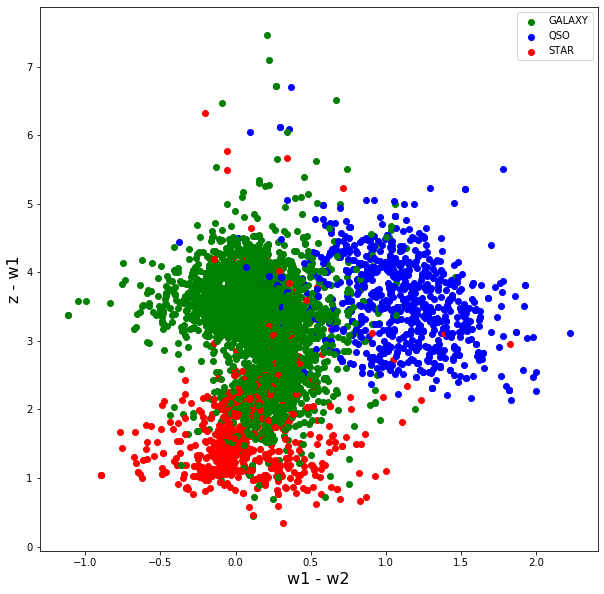

In [20]:
# create a figure and axis
fig, ax = pl.subplots(figsize=(10,10))
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# defining specific colours for each class
colors = {'STAR':'r', 'GALAXY':'g', 'QSO':'b'}

# plot each data point
#naxis = len(x.shape[1])
for i in range(len(x[:,0])):
    ax.scatter(x[:,ilabels[0]][i], x[:,ilabels[1]][i],label=data['specclass'][i],color=colors[data['specclass'][i]])
# set a title and labels
#ax.set_title('Iris Dataset')
ax.set_xlabel(labels[ilabels[0]])
ax.set_ylabel(labels[ilabels[1]])
handles, labels = pl.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
pl.legend(by_label.values(), by_label.keys())

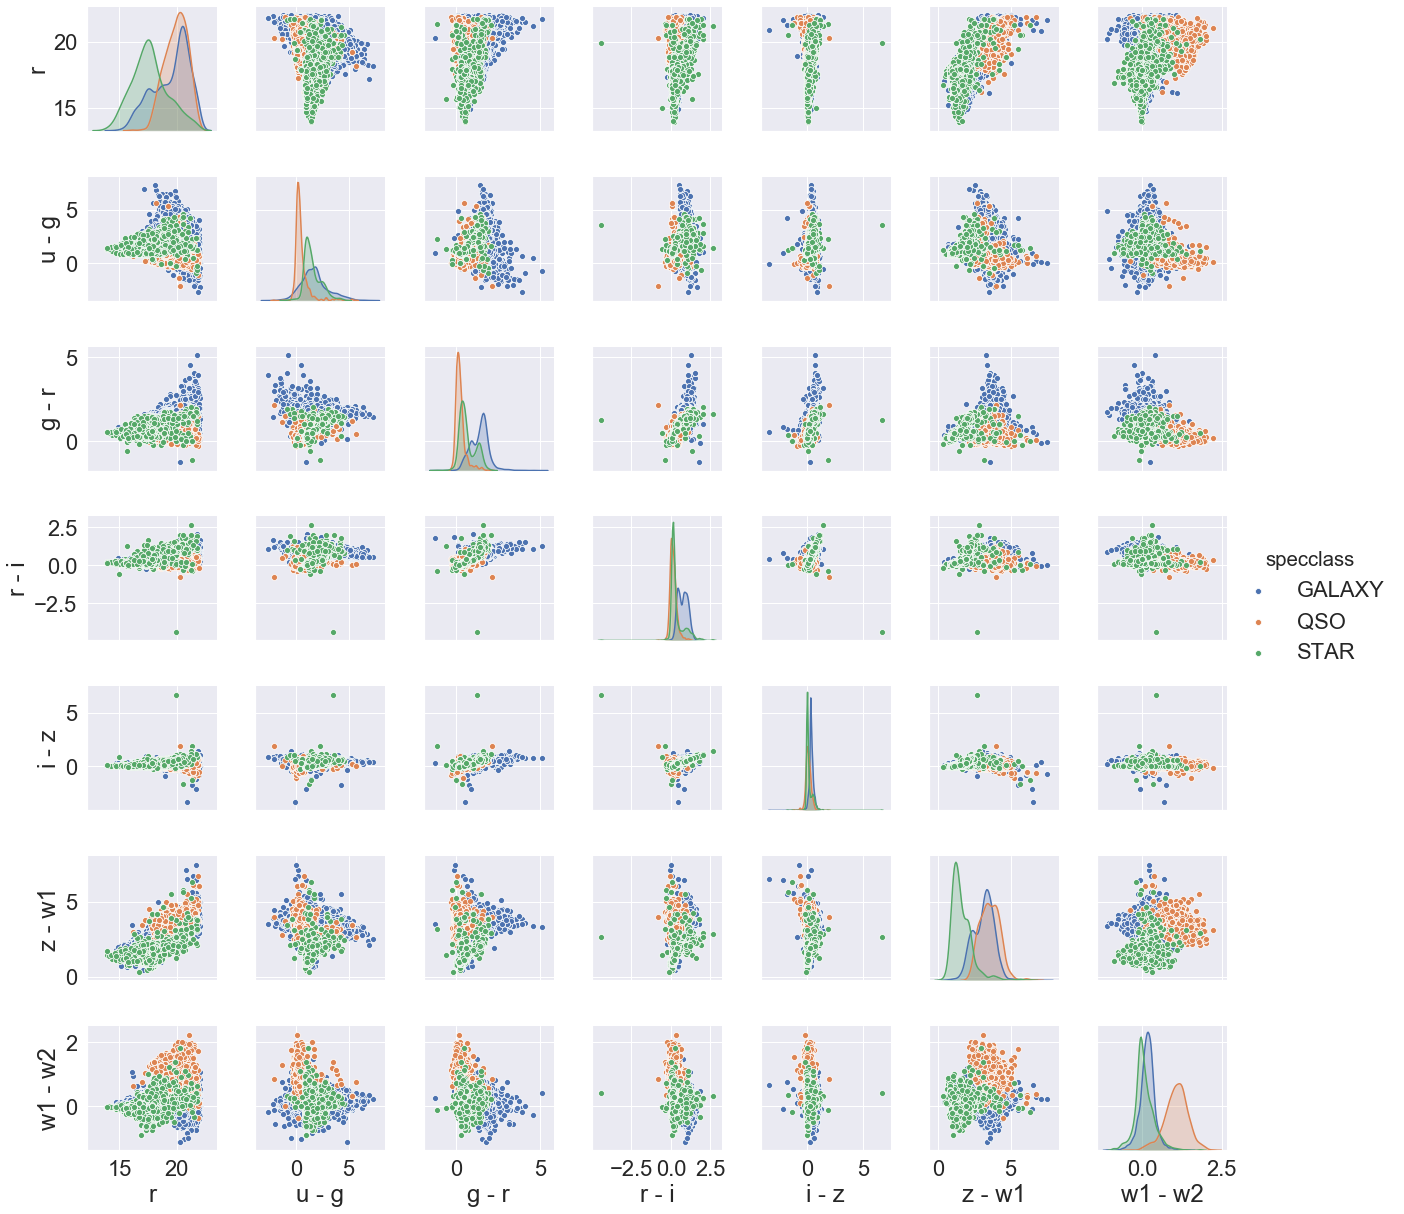

In [21]:
import seaborn as sns
sns.set(font_scale=2)
sns.pairplot(df, hue="specclass",)

# Classification

Classification is a process of grouping objects according to
shared properties and is applied to help understand the origin and evolution of the
objects under consideration. It can be performed using different observed properties of objects, properties like colour, morphology or size. For instance, in the tutorrial to follow, classification is performed differentiate between three classes of [astronomical sources](https://en.wikipedia.org/wiki/Astronomical_object) (stars, galaxies, quasars) using colour properties derived from photometric magnitudes. </br>

### preprocessing the data for classification

In [22]:
# preprocess the data
x_train, x_test, y_train, y_test, i_train, i_test = Preprocessing(file,'C',N=N_all)

### performing classification

In [23]:
#kNearestNeighbor
# using 10 nearest neighbors
ks = KNeighborsClassifier(n_neighbors=10)

y_knn, proba_knn = knn_classifier(ks, x_train, x_test, y_train, y_test)

Elapsed time for knn: 84.18354193900086 seconds
Accuracy for kNN is: 0.9801479956020175
              precision    recall  f1-score   support

      GALAXY     0.9843    0.9812    0.9827     35748
        STAR     0.9682    0.9856    0.9769     74320
         QSO     0.9865    0.9764    0.9815    119128

    accuracy                         0.9801    229196
   macro avg     0.9797    0.9811    0.9803    229196
weighted avg     0.9803    0.9801    0.9802    229196



In [24]:
# RandomForest
# using 30 decision trees
rf = RandomForestClassifier(30)

y_rf, proba_rf, importance =rf_classifier(rf, x_train, x_test, y_train, y_test)

Elapsed time for rf: 372.68940404300065 seconds
Accuracy for rf 0.9884029389692665
              precision    recall  f1-score   support

      GALAXY     0.9877    0.9829    0.9853     35748
        STAR     0.9870    0.9899    0.9885     74320
         QSO     0.9895    0.9891    0.9893    119128

    accuracy                         0.9884    229196
   macro avg     0.9881    0.9873    0.9877    229196
weighted avg     0.9884    0.9884    0.9884    229196



### evaluating the performance of the classifiers

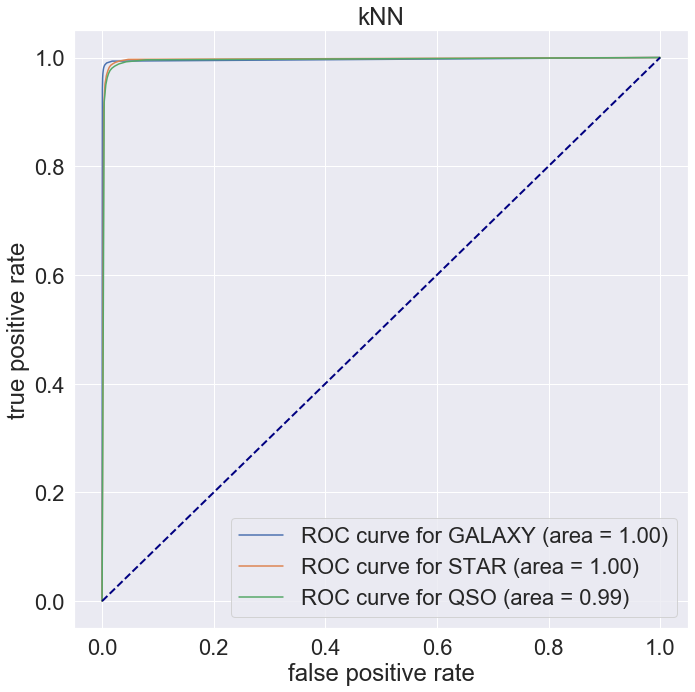

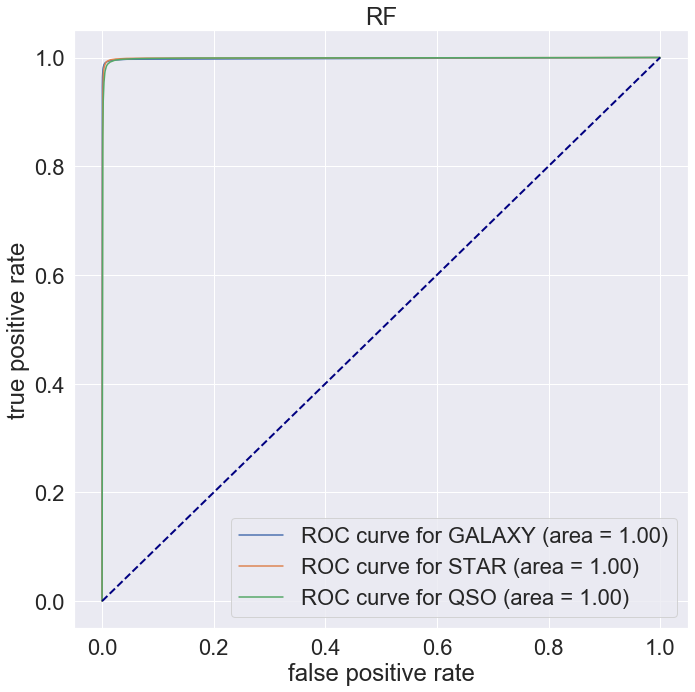

In [25]:
# ROC curve
roc_curve(y_test, proba_knn, 'kNN') #kNN roc_curve

roc_curve(y_test, proba_rf, 'RF') #RF roc_curve

Confusion matrix, without normalization
[[ 35076     67    605]
 [    87  73252    981]
 [   474   2336 116318]]
Normalized confusion matrix
[[0.98 0.   0.02]
 [0.   0.99 0.01]
 [0.   0.02 0.98]]


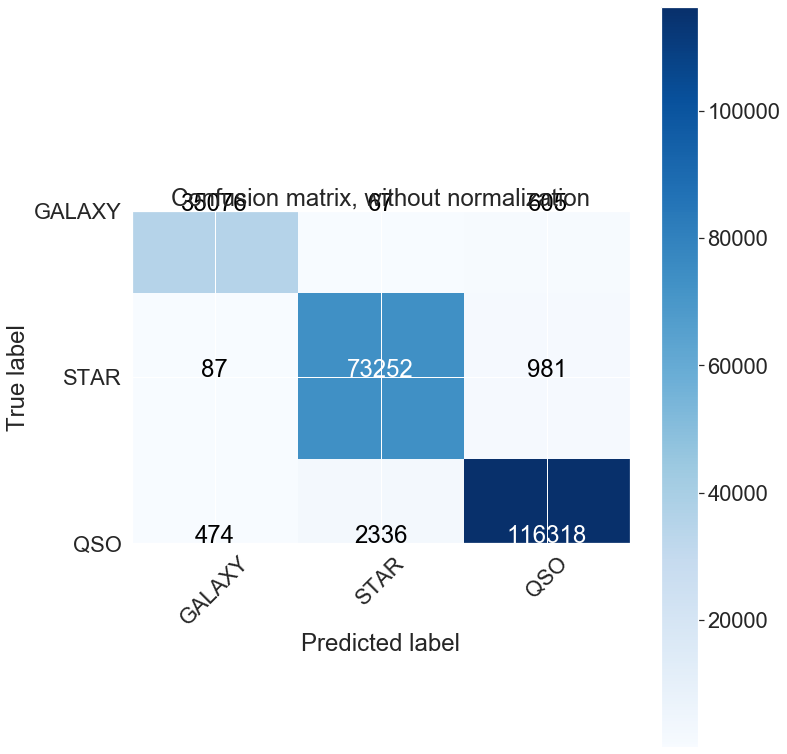

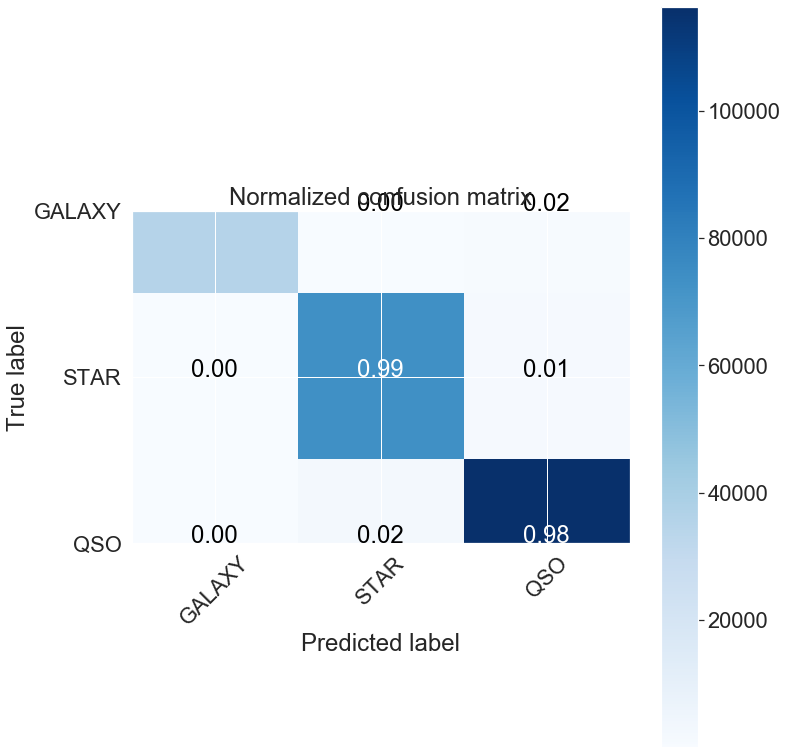

In [26]:
# Compute confusion matrix for kNN classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_knn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(11,11))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

Confusion matrix, without normalization
[[ 35137     55    556]
 [    53  73573    694]
 [   384    916 117828]]
Normalized confusion matrix
[[9.83e-01 1.54e-03 1.56e-02]
 [7.13e-04 9.90e-01 9.34e-03]
 [3.22e-03 7.69e-03 9.89e-01]]


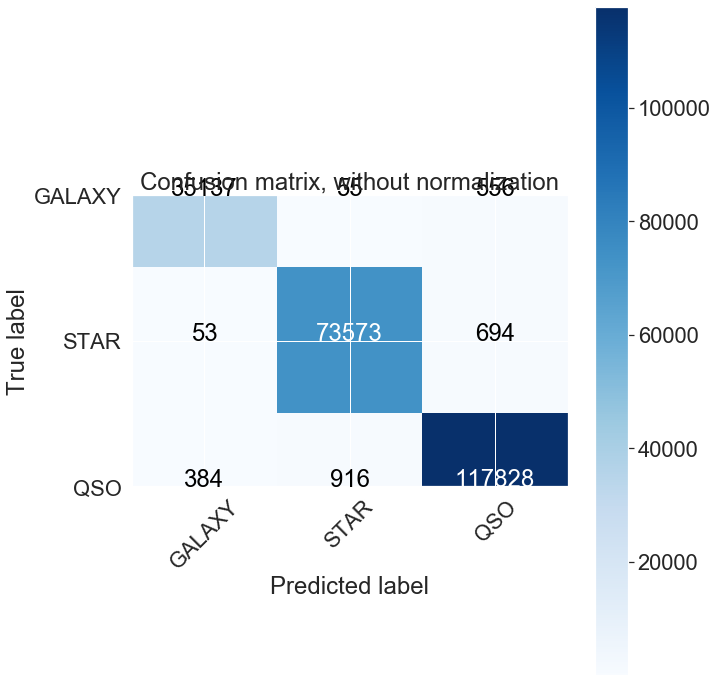

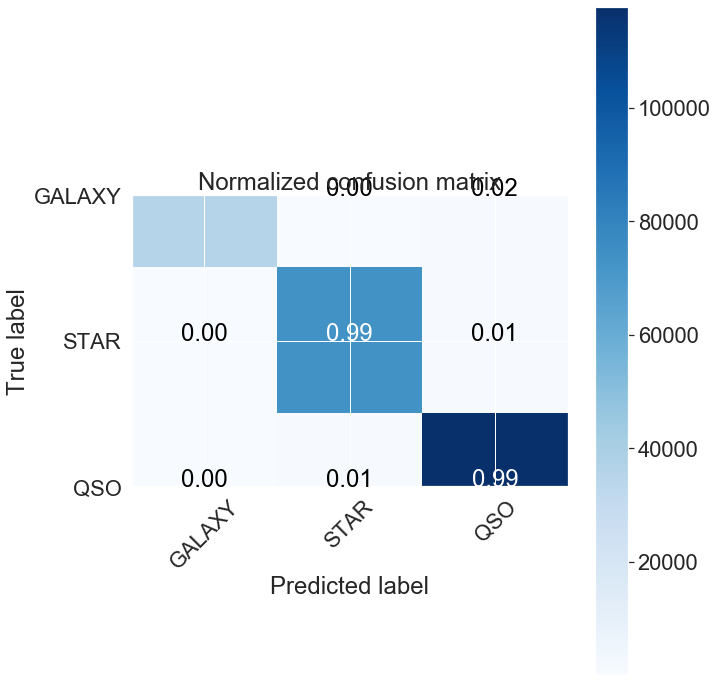

In [27]:
# Compute confusion matrix for Rf classifier
cnf_matrix = metrics.confusion_matrix(y_test, y_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix`
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['GALAXY','STAR','QSO'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
pl.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix,classes=['GALAXY','STAR','QSO'], normalize=True,
                      title='Normalized confusion matrix')

### feature importance



Accuracy for RF (feature selection): 0.9694410024607759
              precision    recall  f1-score   support

      GALAXY     0.9792    0.9755    0.9773     35748
        STAR     0.9585    0.9677    0.9631     74320
         QSO     0.9734    0.9687    0.9711    119128

    accuracy                         0.9694    229196
   macro avg     0.9704    0.9706    0.9705    229196
weighted avg     0.9695    0.9694    0.9695    229196

1. feature 3 (0.218492)
2. feature 4 (0.169316)
3. feature 6 (0.164461)
4. feature 1 (0.157495)
5. feature 5 (0.128469)
6. feature 2 (0.088836)
7. feature 0 (0.072932)


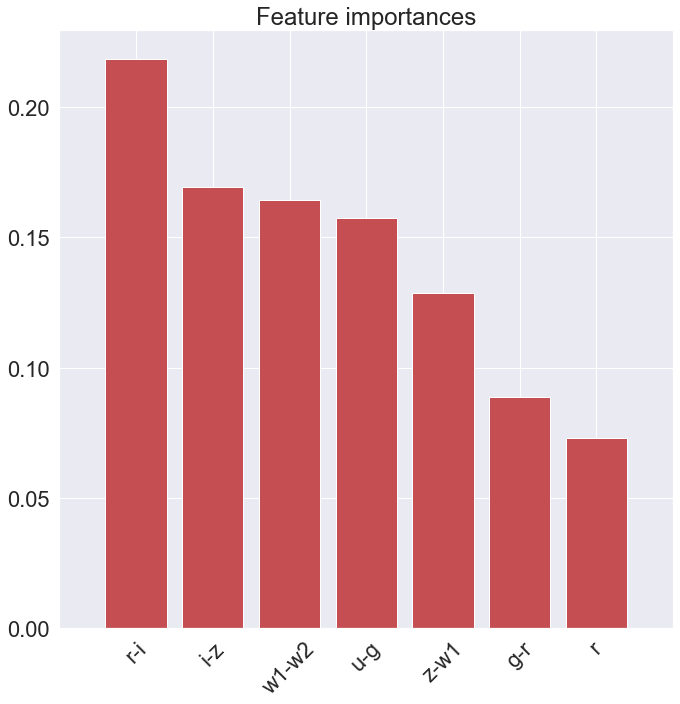

In [28]:
feature_importance(rf,importance,x_train, x_test, y_train, y_test)

# Regression

Regression is defined as a measure of the relation between the values one variable (e.g. output) and corresponding values of other variable(s). In astronomy, regression is popular for mapping the relation between the redshift and the measured properties of the given astronomical source. For instance, in the tutorial to follow, the focus is on the relation between the photometric and the spectroscopic redshifts of the two classes: starforming galaxies (SFGs) and quasars (QSOs).

[Photometric redshift](https://en.wikipedia.org/wiki/Photometric_redshift) (photo-z) is a quantity measured by passing light from a given source through a number of standard broad band filters, the intensity through these different filters is then used to determine the redshift. On the other hand, spectroscopic redshift (spec-z) is measured using the spectral lines observed from the source's spectrum and the measuring the shift in frequency or wavelength of the observed emission/absorption line.</br>

Due to the fact that spectroscopic measurements can be expensive and a high wavelength resolution spectrograph is required to be able to accurately identify the lines. Also, spectroscopic measurements are limited by the faint sources. One of the main advantages of the photometric measurements is that the broad band flux measurements of all identified sources from imaging surveys can be used to estimate the photo-z of the given source. As a result, because of the complementary nature betweem photo- and spec-z, astronomers usually study large samples of photo-z estimates available, allowing for statistical anyalysis to be carried out.

### visualizing colour-colour plot as a function of spectroscopic redshift

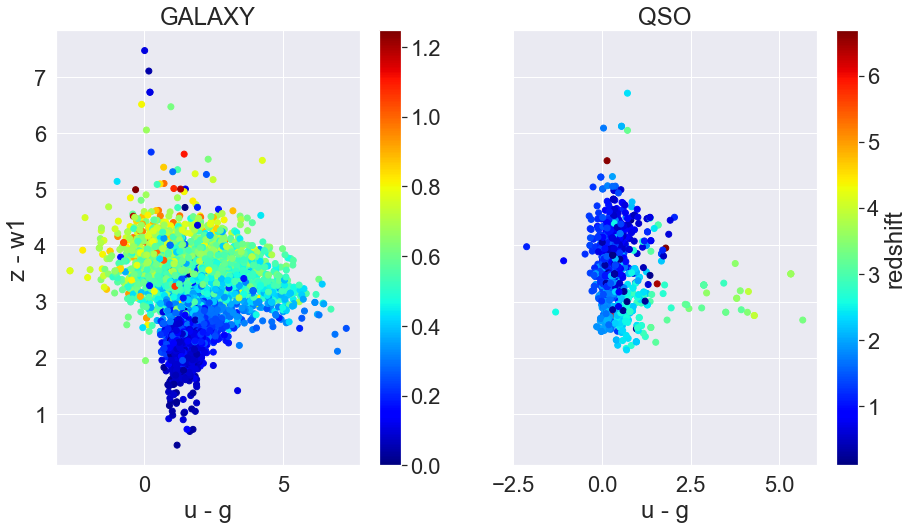

In [29]:
# create a figure and axis
labels = ["r","u - g","g - r","r - i","i - z","z - w1","w1 - w2"]
nlabels = len(labels)

# select two random features
ilabels = np.random.choice(nlabels,2)

# select GALAXY and QSO datasets only
i_gal = np.where(data['specclass']=='GALAXY')[0]
gal = x[i_gal] # GALAXY features
z_gal = data['zspec'][i_gal] # GALAXY spectroscopic redshifts

i_qso = np.where(data['specclass']=='QSO')[0]
qso = x[i_qso] # QSO features
z_qso = data['zspec'][i_qso] # QSO spectroscopic redshifts

# plot data points
fig, ax = pl.subplots(1,2,sharey=True,figsize=(15,8))

ax[0].set_title('GALAXY')
p = ax[0].scatter(gal[:,ilabels[0]], gal[:,ilabels[1]], c=z_gal, cmap='jet') 

ax[0].set_xlabel(labels[ilabels[0]])
ax[0].set_ylabel(labels[ilabels[1]])
pl.colorbar(p,ax=ax[0])

ax[1].set_title('QSO')

p1 = ax[1].scatter(qso[:,ilabels[0]], qso[:,ilabels[1]], c=z_qso, cmap='jet')
ax[1].set_xlabel(labels[ilabels[0]])
pl.colorbar(p1,ax=ax[1], label='redshift')


### preprocessing the data for photo-z regression

In [14]:
x_data, y_data,i_gal, i_qso = Preprocessing(file, 'r', N=N_all)

Number of galaxies: 595336


Number of quasars: 180447


#### GALAXY

delta(z)_mean = 0.0005365390097722411; delta(z)_median = 0.00025962881045416; sigma(delta(z)) = 0.01997927576303482; nmad(delta(z)) = 0.014293568582832813
sigma1 = 20.584678232124382; sigma2 = 3.4105110391442817; sigma3 = 0.7780480266605749; sigma0.15 = 0.09876775467971027


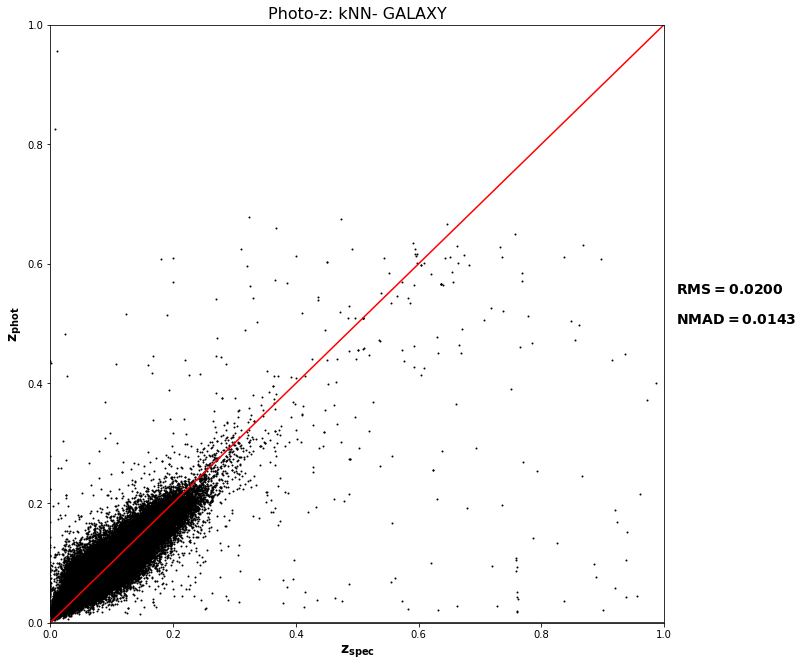

In [51]:
# kNearestRegressor
# using 10 nearest neighbors 
kg = KNeighborsRegressor(n_neighbors=10, weights='uniform')
regressor(kg,x_data,y_data, i_gal, i_qso, 'kNN', 'GALAXY', [[0.0,1.0],[0.0,1.0]])

delta(z)_mean = 0.0004166844428320296; delta(z)_median = 0.00015471011975444883; sigma(delta(z)) = 0.01829345044291378; nmad(delta(z)) = 0.011272123146018026
sigma1 = 18.30428531115202; sigma2 = 3.438730397624199; sigma3 = 0.8707687759517314; sigma0.15 = 0.09608019672924198


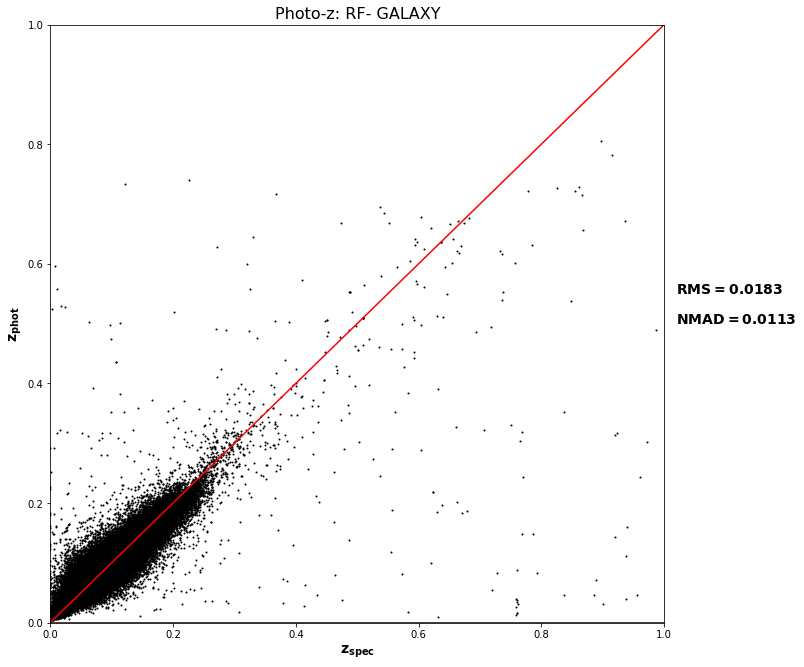

In [52]:
### RandomForestRegressor
#using 30 number of decision trees
rfg = RandomForestRegressor(30)
regressor(rfg,x_data,y_data, i_gal, i_qso, 'RF', 'GALAXY', [[0.0,1.0],[0.0,1.0]])

#### QSO

delta(z)_mean = 0.008636846207082272; delta(z)_median = 4.044027809868567e-05; sigma(delta(z)) = 0.11048083007335663; nmad(delta(z)) = 0.03334955940172076
sigma1 = 6.869862381084327; sigma2 = 3.112588898125058; sigma3 = 2.037498845478895; sigma0.15 = 4.810196730396232


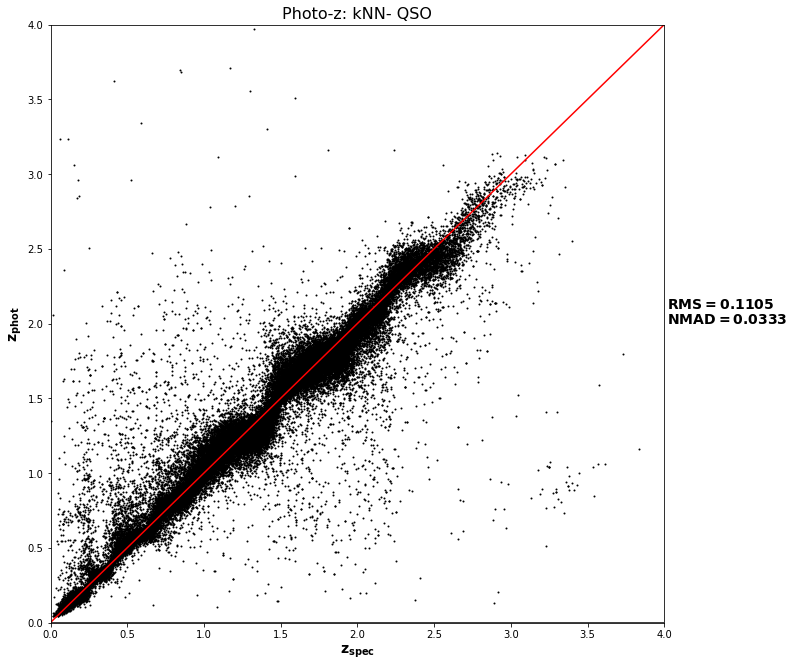

In [53]:
# kNearestRegressor
# using 10 nearest neighbors 
kg = KNeighborsRegressor(n_neighbors=10, weights='uniform')
regressor(kg,x_data,y_data, i_gal, i_qso, 'kNN', '', [[0.0,4.0],[0.0,4.0]])

delta(z)_mean = 0.009975470818778845; delta(z)_median = 0.00017036169475627693; sigma(delta(z)) = 0.10583414050601113; nmad(delta(z)) = 0.023246821992721843
sigma1 = 6.417290108063176; sigma2 = 2.8779902096610326; sigma3 = 1.7382469751547058; sigma0.15 = 4.339152119700748


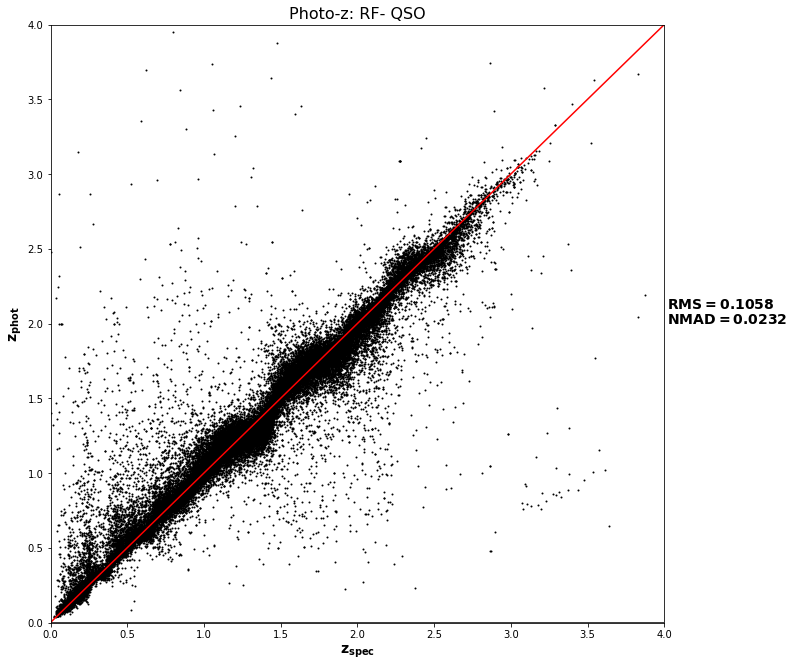

In [54]:
# RandomForestRegressor
# using 30 number of decision trees
rfg = RandomForestRegressor(30)
#regressor(rfg,x_train, x_test, y_ztrain, y_ztest, i_train, i_test, i_gal, i_qso, 'RF', '', [-2.0,2.0])
regressor(rfg,x_data,y_data, i_gal, i_qso, 'RF', '', [[0.0,4.0],[0.0,4.0]])